In [1]:
import numpy as np

In [196]:
class DeepNN():
    def __init__(self, X, Y, dims_of_layers, activations, alpha = 0.01):
        #dims_of_layers - list of number of units in each layer (first element - num of features in input)
        #activations - activation function applied to each layer

        #dims_of_layers[0] - n of features in input
        #activations[0] - activation for first hidden layer
        #we support only 3 activation funcs: linear, sigmoid, relu

        #X.shape should be (n_features, m_examples)
        #Y.shape should be (1, m_examples)
        self.X = X
        self.Y = Y

        self.m_examples = X.shape[1]

        self.dims_of_layers = dims_of_layers
        self.n_layers = len(activations)

        self.activations = activations
        self.params = dict()

        self.learning_history = []
        self.alpha = alpha

        #setting cache dicts for backpropogation

        self.cache = dict()

    def initialize_params(self):

        for i in range(1, len(self.activations) + 1):

            #setting parameters layer by layer
            self.params["W" + str(i)] = np.random.randn(self.dims_of_layers[i], self.dims_of_layers[i-1])
            self.params["b" + str(i)] = np.zeros((self.dims_of_layers[i], 1))



    def activation(self, Z, function="linear"):
        if function == "linear":
            return Z

        if function == "sigmoid":
            return 1 / (1 + np.exp(-Z))

        if function == "relu":
            return Z * (Z > 0)


    def deriv_activation(self, Z, function):
        if function == "linear":
            return 1.

        if function == "sigmoid":
            sigm_z = self.activation(Z, "sigmoid")

            return sigm_z *(1 - sigm_z)

        if function == "relu":
            return 1. * (Z > 0)



    def forward_propogation(self, X):

        #X.shape = (n_features, m_examples)

        A_prev = X
        self.cache["A0"]  = A_prev

        Z_current = np.dot(self.params["W1"], A_prev) + self.params["b1"]
        A_current = self.activation(Z_current, function=self.activations[0])

        self.cache["Z1"] = Z_current
        self.cache["A1"] = A_current

        for i in range(1, len(self.activations)):
            A_prev = A_current

            #A_prev - cache["A" + str(i)]
            Z_current = np.dot(self.params["W" + str(i+1)], A_prev) + self.params["b" + str(i+1)]
            A_current = self.activation(Z_current, function=self.activations[i])

            #keeping values in cache for backprop
            self.cache["Z" + str(i+1)] = Z_current
            self.cache["A" + str(i+1)] = A_current


        predictions = A_current

        return predictions

    def compute_cost(self, predictions, cost_function="cross_entropy"):
        #leave cost func as a parameter
        #so that we can use it futher not only for classification




        if cost_function == "cross_entropy":

            #lets cut off a  tiny constant to avoid log0 problem
            epsilon = 10 ** -15

            predictions = np.clip(predictions, epsilon, 1-epsilon)

            #BinaryCrossEntropy

            cost = (self.Y * np.log(predictions) +
                    (1 - self.Y) * np.log(1 - (predictions)) ) * (-1 / self.m_examples)

            cost = np.sum(cost, axis=1, keepdims=True) #sum up the columns

        #we will have more cost functions here later...

        return cost

    def deriv_of_cost(self, predictions, cost_function="cross_entropy"):

        if cost_function == "cross_entropy":

            #avoiding division by zero
            epsilon = 10 ** -15
            predictions = np.clip(predictions, epsilon, 1-epsilon)

            dAL = (predictions - self.Y) / (predictions * (1 - predictions))

        #we will have more cost functions here later...

        return dAL


    def back_propogation(self, predictions, cost_func="cross_entropy"):

        L = self.n_layers

        grads_cache = dict()

        for i in range(L, 0, -1):
            if i == L:
                dA_i = self.deriv_of_cost(predictions, cost_function=cost_func)
            else:

                dA_i = np.dot(self.params["W" + str(i+1)].T, grads_cache["dZ" + str(i+1)]) #ERROR MuSt be here
                #print("i =", i)
                # print("W=", self.params["W" + str(i+1)] )
                # print("dZ_next =", grads_cache["dZ" + str(i+1)])

                # print("W = ", self.params["W" + str(i+1)].T.shape)
                # print("W shape ", )
                # print("dZ shape" + str(i),  grads_cache["dZ" + str(i+1)].shape)
                #print("dA", dA_i)


            grads_cache["dA" + str(i)] = dA_i
            activation_i = self.activations[i-1]

            Z_i = self.cache["Z" + str(i)]
            A_prev = self.cache["A" + str(i-1)]
            W_i = self.params["W" + str(i)]

            #print("Activation = ", activation_i)
            dZ_i = dA_i * self.deriv_activation(Z_i, activation_i)

            #print("Sum of dZ_i", np.sum(dZ_i))

            #computing derivs for W, b
            dW_i = (1 / self.m_examples) * np.dot(dZ_i, A_prev.T)
            db_i = (1/ self.m_examples) * np.sum(dZ_i, axis=1, keepdims=True)


            #storing gradients
            grads_cache["dZ" + str(i)] = dZ_i
            grads_cache["dW" + str(i)] = dW_i
            grads_cache["db" + str(i)] = db_i

        return grads_cache

    def update_params(self, grads):

        for i in range(1, self.n_layers + 1):

            #updating by Gradient Descent
            self.params["W" + str(i)] -=  self.alpha * grads["dW" + str(i)]
            self.params["b" + str(i)] -= self.alpha * grads["db" + str(i)]


    def fit(self, epochs=100, cost_func="cross_entropy", debug=False):

        #fitting process

        #initialize random params

        history = []
        self.initialize_params()


        for epoch in range(0, epochs + 1):

            predictions = self.forward_propogation(self.X)

            #computing cost function
            cost = np.round(self.compute_cost(predictions, cost_func), 6)
            history.append(cost)


            if (epoch % max(1 , (epochs // 10)) == 0):
              print("Epoch #{},  {} == {}".format(epoch, cost_func, cost))

            #computing gradients
            grads = self.back_propogation(predictions, cost_func="cross_entropy")
            if debug == True:
              print(grads)

            #update params using Gradient Descent
            self.update_params(grads)

        self.history = history

## Trying my DeepNN on syntetic dataset for binary classification



In [191]:
#Simple dataset

X = np.array([[1, 1, 0],
             [1, 0, 0],
             [0, 1, 0],
             [0, 0, 0],
              [1, 0, 1]]).T

y = np.array([1, 1, 0, 0, 1]).reshape(-1, 1).T

units = [3, 1]
activations = ["sigmoid"]

In [192]:
# deepnn = DeepNN(X, y, units, activations, alpha = 0.01)
# history = deepnn.fit(epochs=2000)

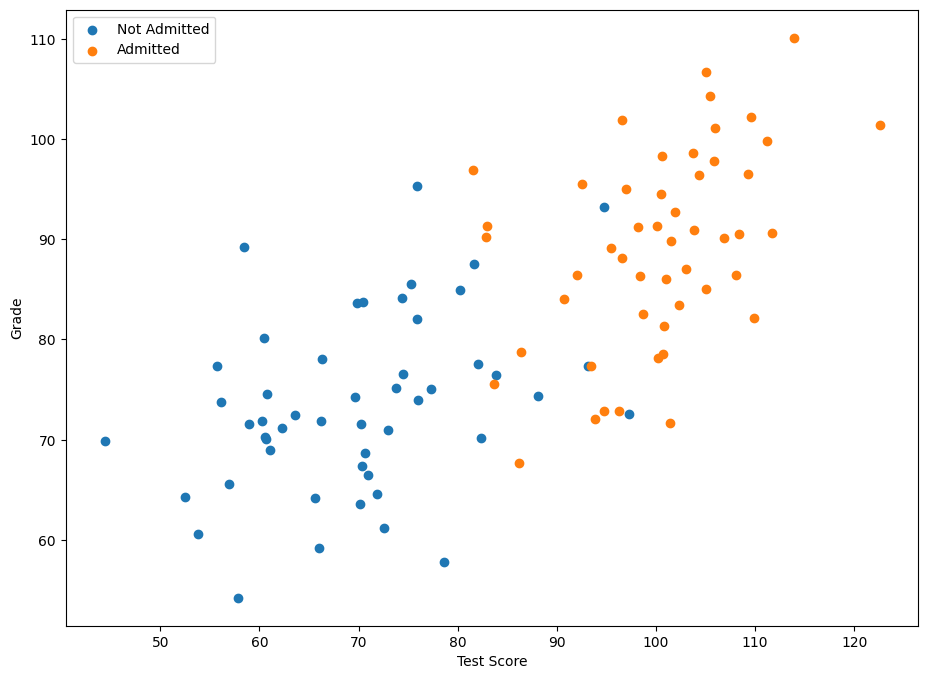

In [240]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Trying on a data

np.random.seed(2004)

# Generate data for not admitted students
mean_not_admitted = [70, 75]
cov_not_admitted = [[100, 50], [50, 100]]
not_admitted = np.random.multivariate_normal(mean_not_admitted, cov_not_admitted, size=50)

# Generate data for admitted students
mean_admitted = [100, 90]
cov_admitted = [[100, 50], [50, 100]]
admitted = np.random.multivariate_normal(mean_admitted, cov_admitted, size=50)

# Combine the data
X = np.vstack((not_admitted, admitted)) / 100
y = np.hstack((np.zeros(50), np.ones(50)))



# Plot the generated data

plt.figure(figsize=(11, 8))
plt.scatter(not_admitted[:, 0], not_admitted[:, 1], label="Not Admitted")
plt.scatter(admitted[:, 0], admitted[:, 1], label="Admitted")
plt.xlabel("Test Score")
plt.ylabel("Grade")
plt.legend()
plt.show()

In [259]:
#my DeepNN

X_train,  X_test, y_train,y_test = train_test_split(X, y, random_state=1)




#transform for our NN

X_train = X_train.T
X_test = X_test.T

y_train = y_train.reshape(-1, 1).T
y_test = y_test.reshape(-1, 1).T



#Yes, I guess, it is too complicated for such a simple dataset
units = [X.shape[1], 5 , 5,  1]
activations = ["relu" , "relu" ,"sigmoid"]






In [255]:



deepnn = DeepNN(X_train, y_train, units, activations, alpha = 0.01)
deepnn.fit(3000, debug=False)

Epoch #0,  cross_entropy == [[0.720188]]
Epoch #300,  cross_entropy == [[0.689194]]
Epoch #600,  cross_entropy == [[0.680855]]
Epoch #900,  cross_entropy == [[0.670203]]
Epoch #1200,  cross_entropy == [[0.654631]]
Epoch #1500,  cross_entropy == [[0.628584]]
Epoch #1800,  cross_entropy == [[0.58154]]
Epoch #2100,  cross_entropy == [[0.488897]]
Epoch #2400,  cross_entropy == [[0.405098]]
Epoch #2700,  cross_entropy == [[0.343269]]
Epoch #3000,  cross_entropy == [[0.299771]]


In [257]:
predictions = np.round(np.array(deepnn.forward_propogation(X_test)).T)


In [258]:
from sklearn.metrics import accuracy_score


accuracy_score(y_test.T, predictions)

0.96